In [49]:
import numpy as np, pandas as pd
from glob import glob
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar

%matplotlib inline

Sample was generated using queries similar to the following, in slices in Galactic longitude. So assuming distances from Bailer-Jones, we can pick out lots of bright things!
```
SELECT gaia.source_id, wise_match.original_ext_source_id, wise_match.allwise_oid, wise.designation, gaia.ra, gaia.dec, gaia.parallax, gaia.parallax_error, gaia.a_g_val, gaia.phot_g_mean_mag, gaia.phot_bp_mean_mag, gaia.phot_rp_mean_mag, gaia_dist.r_est, gaia_dist.r_lo, gaia_dist.r_hi, gaia_dist.r_len, wise.w1mpro, wise.w1mpro_error, wise.w2mpro, wise.w2mpro_error
FROM gaiadr2.gaia_source as gaia 
INNER JOIN external.gaiadr2_geometric_distance as gaia_dist ON gaia.source_id = gaia_dist.source_id
INNER JOIN gaiadr2.allwise_best_neighbour as wise_match ON gaia.source_id = wise_match.source_id
INNER JOIN gaiadr1.allwise_original_valid as wise ON wise_match.allwise_oid=wise.allwise_oid
WHERE  gaia.phot_g_mean_mag - 5 * log10(gaia_dist.r_est) + 5 - gaia.a_g_val <= 0
AND gaia.l >= 300
AND gaia.l < 360
AND wise.w1mpro < 14
AND gaia_dist.result_flag > 0 
```

In [2]:
tables = glob('bright_*result.csv')
#check that we're only getting the files we want
tables

['bright_0-15-result.csv',
 'bright_120-180-result.csv',
 'bright_15-30-result.csv',
 'bright_180-240-result.csv',
 'bright_240-270-result.csv',
 'bright_270-285-result.csv',
 'bright_285-300-result.csv',
 'bright_30-45-result.csv',
 'bright_300-315-result.csv',
 'bright_315-330-result.csv',
 'bright_330-345-result.csv',
 'bright_345-360-result.csv',
 'bright_45-60-result.csv',
 'bright_60-75-result.csv',
 'bright_75-90-result.csv',
 'bright_90-120-result.csv']

In [3]:
#Put together the individual results
dfs = []
for t in tables:
    temp = pd.read_csv(t)
    dfs.append(temp)
    
result = pd.concat(dfs)
len(result)

3846981

In [4]:
result.columns

Index(['source_id', 'original_ext_source_id', 'allwise_oid', 'designation',
       'ra', 'dec', 'parallax', 'parallax_error', 'a_g_val', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'r_est', 'r_lo', 'r_hi',
       'r_len', 'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error'],
      dtype='object')

In [5]:
#Synthesize Gaia M_G mag
M_G = result['phot_g_mean_mag'] - 5 * np.log10(result['r_est']) + 5 - result['a_g_val']
result['M_G'] = M_G

#Now synthesize unextincted colors, using coefficients from Malhan, Ibata & Martin (2018a)
ag_av = 0.85926
ab_av = 1.06794
ar_av = 0.65199

e_br = (result['a_g_val']/ag_av)*(ab_av - ar_av)
result['E(BP-RP)'] = e_br
result['(BP_RP)_0'] = result['phot_bp_mean_mag'] - result['phot_rp_mean_mag'] - result['E(BP-RP)']

#now W1-W2 and M_W1
w1w2 = result['w1mpro']-result['w2mpro']
MW1 = result['w1mpro'] - 5 * np.log10(result['r_est']) + 5
result['W1-W2'] = w1w2
result['M_W1'] = MW1

In [6]:
#Now let's try to isolate massive stars using MIST. Take all isochrones with initial mass > 8
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

MWnames = ('EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',
           'log_g','log_L','[Fe/H]_init','[Fe/H]','WISE_W1','WISE_W2','WISE_W3',
           'WISE_W4','phase')

Mfile = '../MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
MWfile = '../MIST/MIST_v1.1_vvcrit0.4_WISE/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_WISE.iso.cmd'

mist = pd.read_table(Mfile, delim_whitespace=True, comment='#', names=Mnames)
mist_w = pd.read_table(MWfile, delim_whitespace=True, comment='#', names=MWnames)

mist_massive = mist[(mist['initial_mass'] >= 8)]
mist_MS = mist[(mist['EEP'] >= 202)&(mist['EEP']<=454)]

mist_wmassive = mist_w[(mist_w['initial_mass'] >= 8)]
mist_wMS = mist_w[(mist_w['EEP'] >= 202)&(mist_w['EEP']<=454)]

#Now, in each color bin, give me the color and magnitude of the faintest star.
col_bins = np.linspace(-0.25,3,100)
min_cols = []
min_mags = []

min_wcols = []
min_wmags = []

for i,left in enumerate(col_bins[:-1]):
    mist_subset = mist_massive[(mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']>left)&
                               (mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']<=col_bins[i+1])]
    min_point = mist_subset[mist_subset['Gaia_G_DR2Rev']==np.max(mist_subset['Gaia_G_DR2Rev'])]
    if len(min_point) != 0:
        min_cols.append((min_point['Gaia_BP_DR2Rev'].values-min_point['Gaia_RP_DR2Rev'].values)[0])
        min_mags.append((min_point['Gaia_G_DR2Rev'].values)[0])

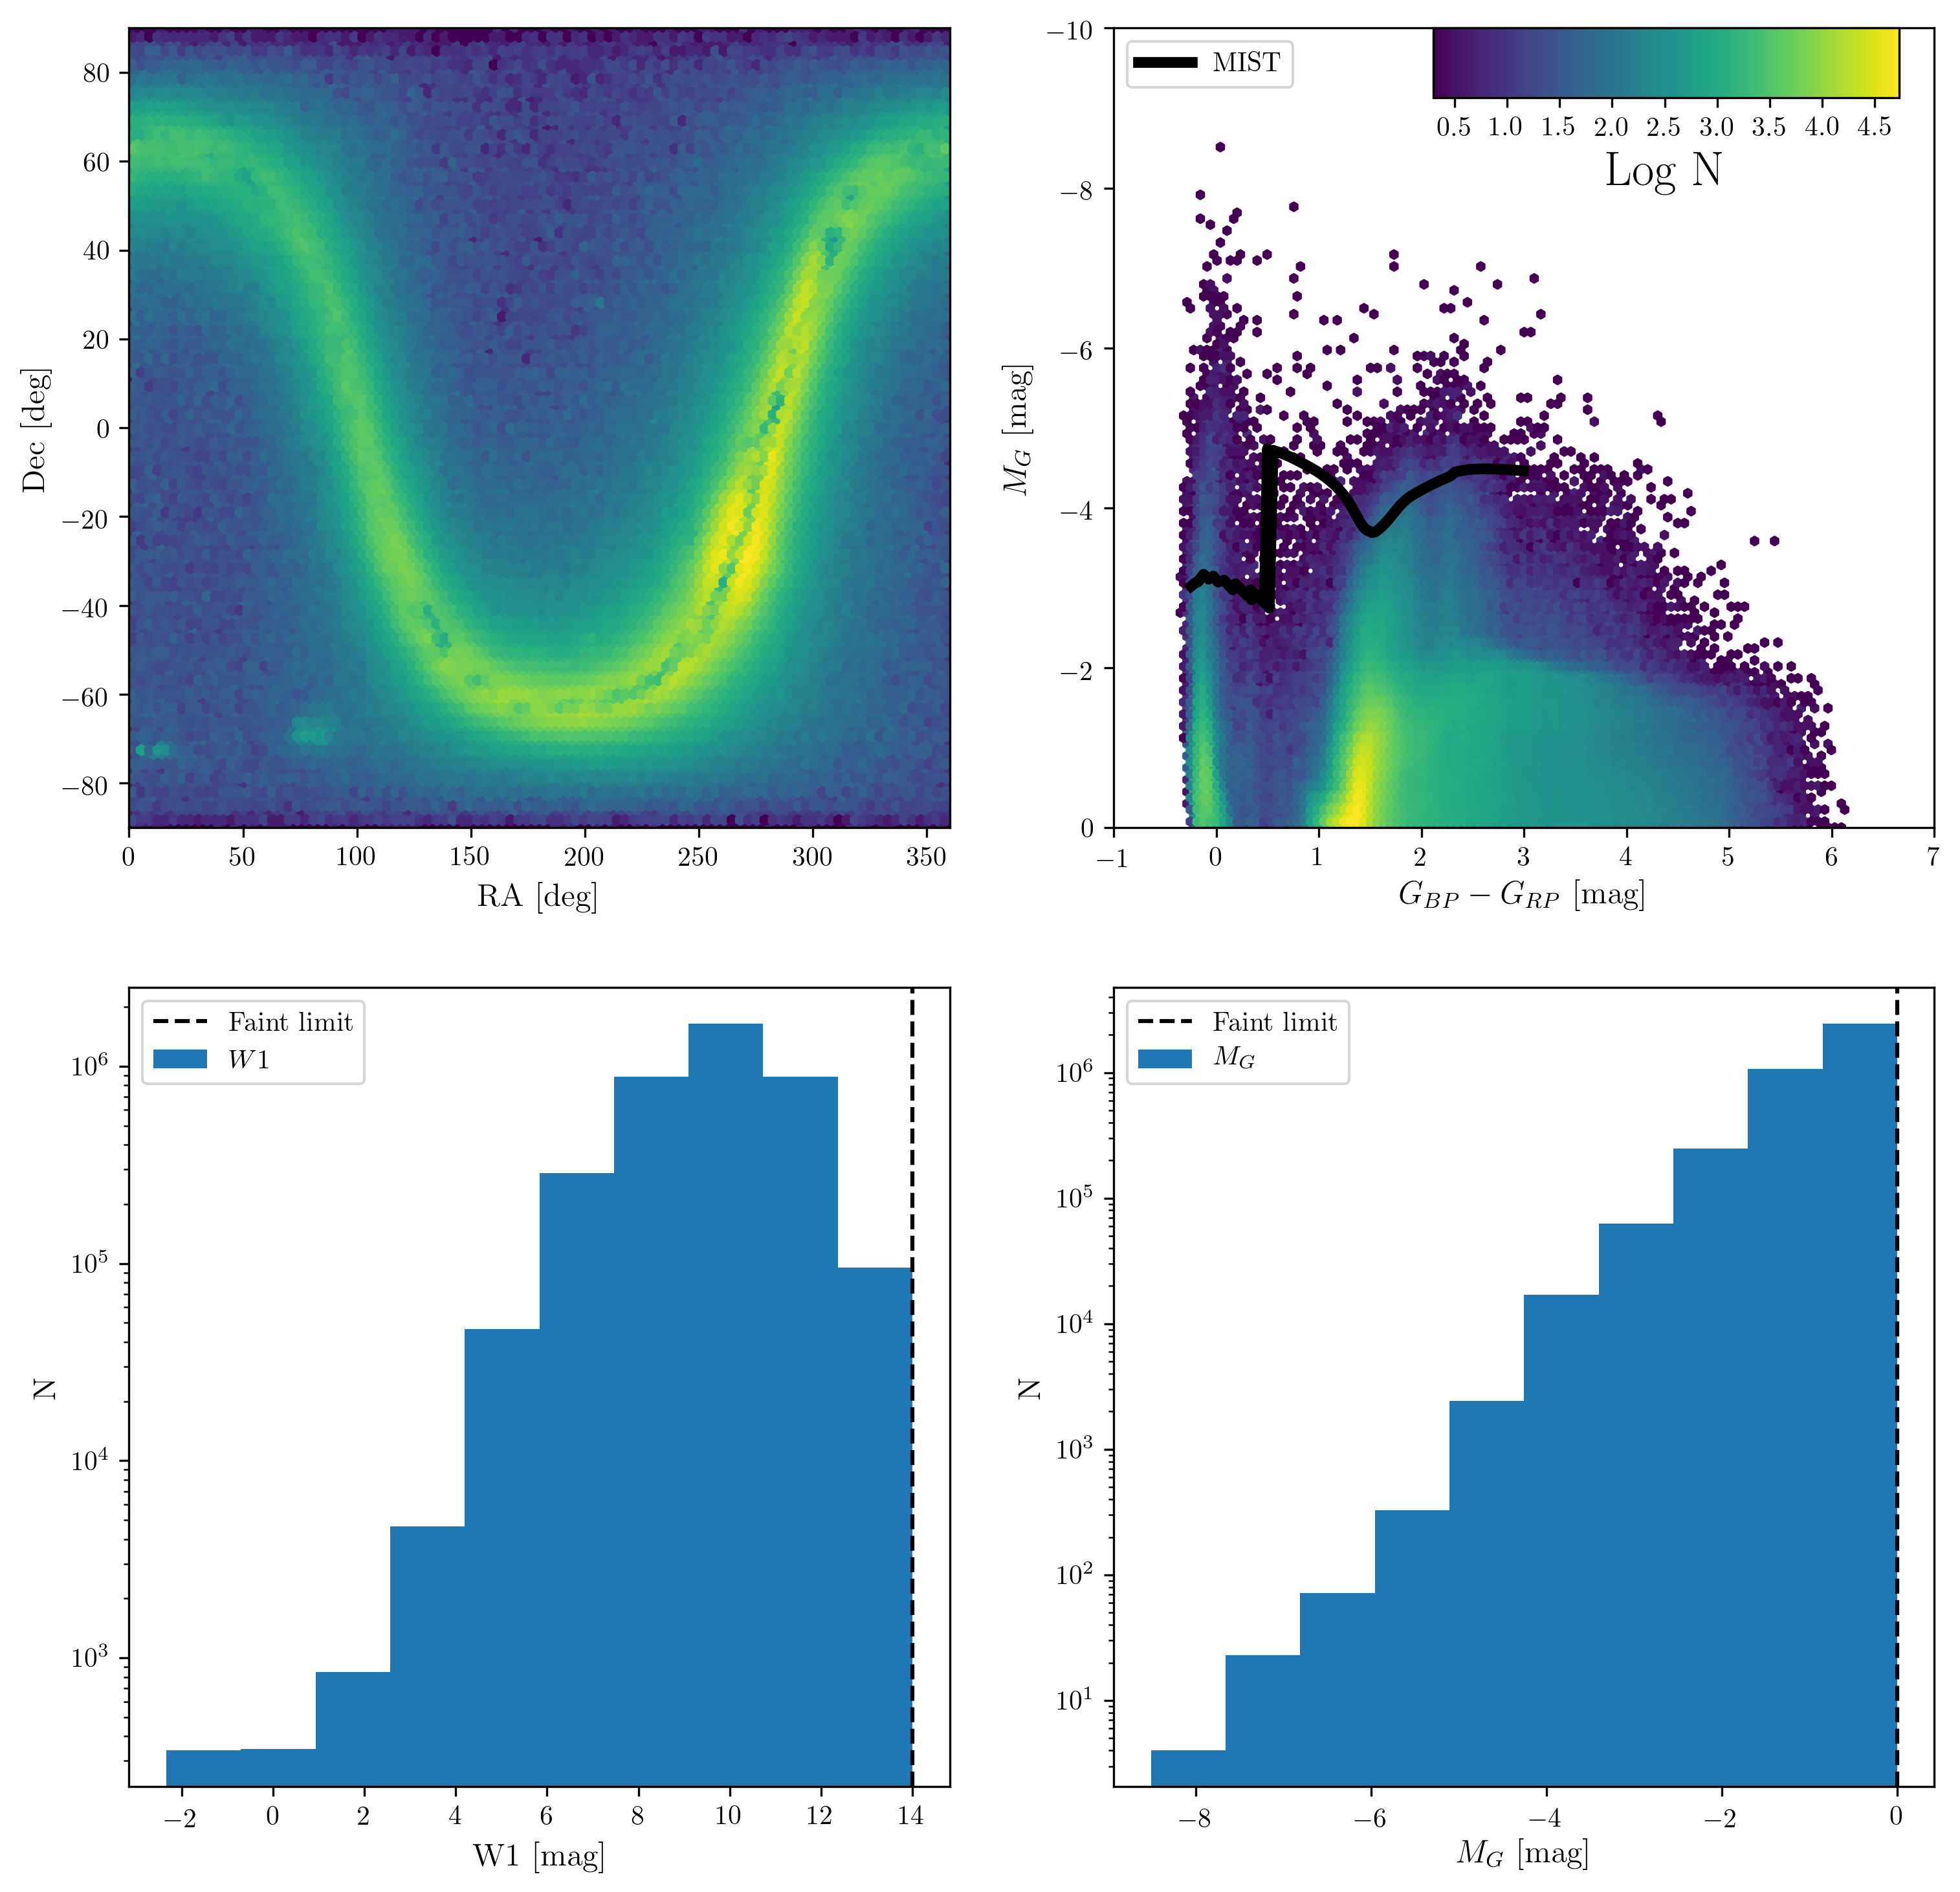

In [50]:
#Check for all the conditions we have
fig, axes = plt.subplots(2,2,figsize=(12,12),dpi=300)

axes[0,0].hexbin(result['ra'],result['dec'],bins='log')
axes[0,0].set(xlim=(0,360),ylim=(-90,90),xlabel='RA [deg]',ylabel='Dec [deg]')

axes[0,1].plot(min_cols,min_mags,'-k',lw=4,label='MIST')
axes[0,1].legend(loc=2)
hexb = axes[0,1].hexbin(result['(BP_RP)_0'],result['M_G'],mincnt=1,bins='log')
axes[0,1].set(xlim=(-1,7), ylim=(0,-10), xlabel=(r'$G_{BP}-G_{RP}$ [mag]'), ylabel=('$M_G$ [mag]'))

hexclim = hexb.get_clim()
cbax = fig.add_subplot(111)
cbax.set_position([0.685,0.85, 0.2, 0.03])
norm = colors.Normalize(vmin=hexclim[0], vmax=hexclim[1])
cb1 = cbar.ColorbarBase(cbax, cmap='viridis',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Log N',fontsize=18)

axes[1,0].hist(result['w1mpro'],label='$W1$')
axes[1,0].axvline(x=14,label='Faint limit',ls='--',c='k')
axes[1,0].set(xlabel='W1 [mag]',ylabel='N',yscale='log')
axes[1,0].legend()

axes[1,1].hist(result['M_G'],label=r'$M_G$')
axes[1,1].axvline(x=0,label='Faint limit',ls='--',c='k')
axes[1,1].legend()
axes[1,1].set(xlabel=r'$M_G$ [mag]',ylabel='N',yscale='log')

plt.savefig('sample.eps')

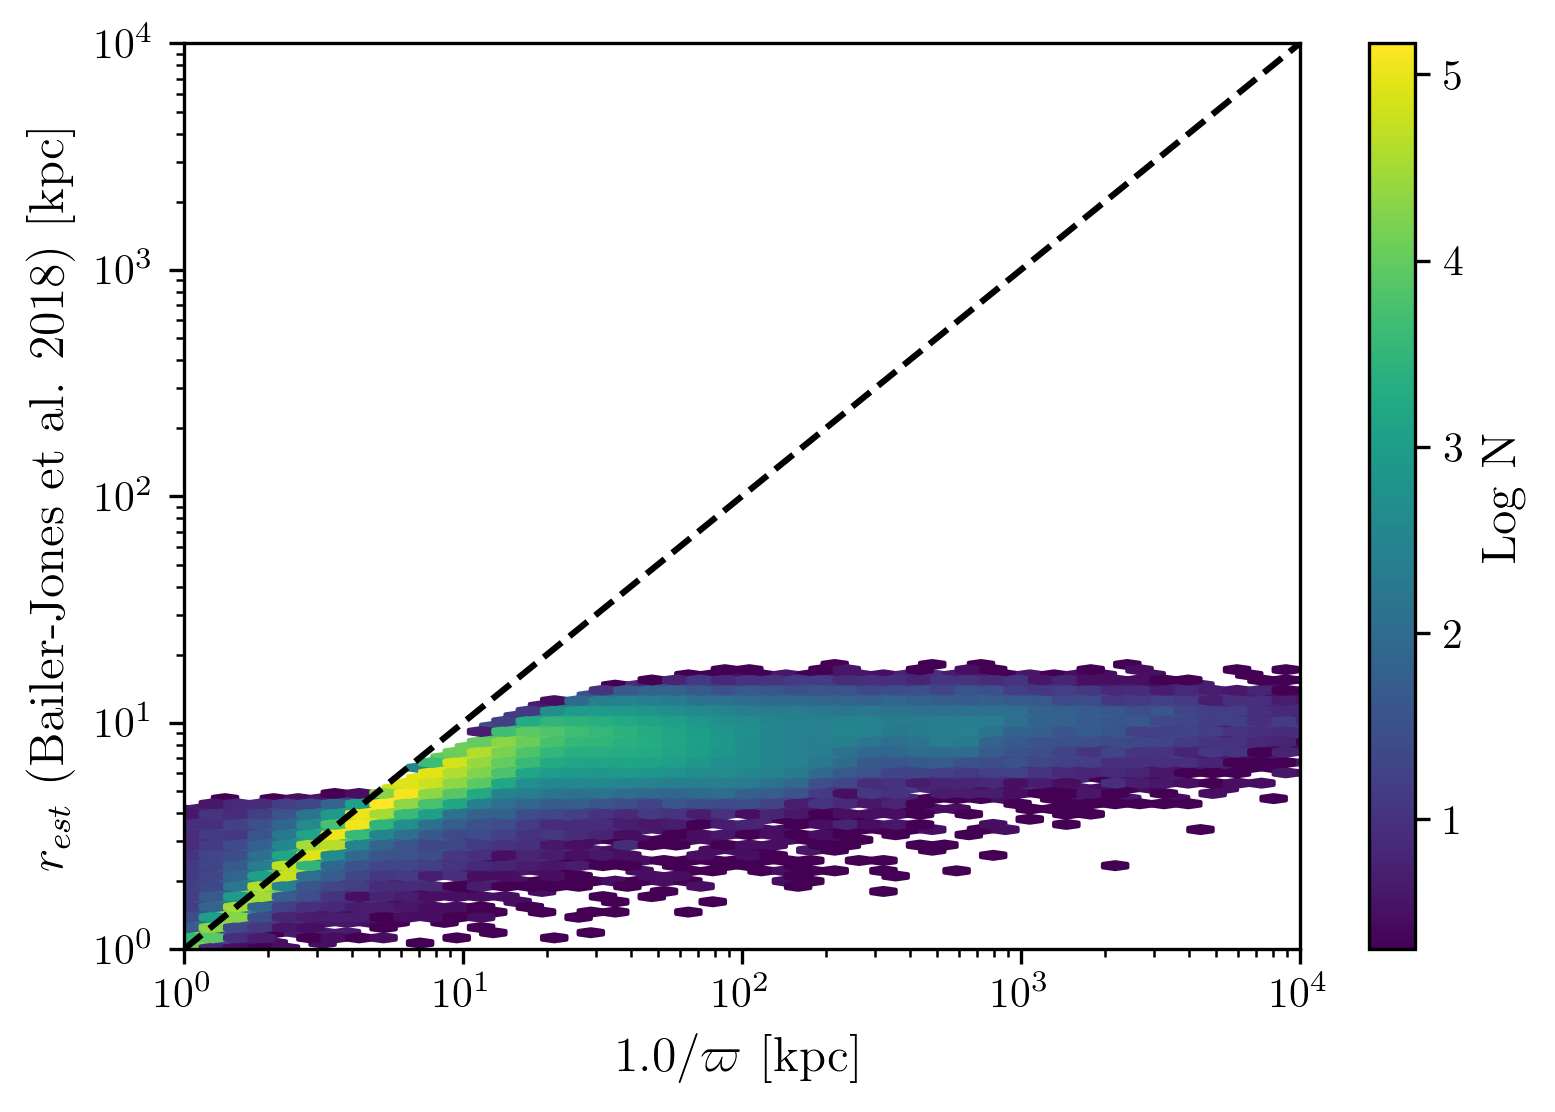

In [42]:
plt.figure(dpi=300)
plt.hexbin(1.0/result['parallax'],1.0e-3*result['r_est'],bins='log',
          mincnt=1,xscale='log',yscale='log')
plt.colorbar(label='Log N')
plt.plot([1,1e4],[1,1e4],'--k',label='1 to 1')
plt.xlim(1,1e4)
plt.ylim(1,1e4)
plt.xlabel(r'$1.0/\varpi$ [kpc]')
plt.ylabel(r'$r_{est}$ (Bailer-Jones et al. 2018) [kpc]')
plt.savefig('dist_invparallax.eps')

In [7]:
#Ok, so we can run all of the colors through an interpolater
#We can then check... if M_G >= border mags, then we'll call it massive.
border_mags = np.interp(result['(BP_RP)_0'], min_cols, min_mags)

In [8]:
#We can also do some cuts using WISE data
#We'll select for SNR in flux densities instead of magnitudes...
w1_zp = 20.5
w2_zp = 19.5

w1_flux = np.power(10.0,(w1_zp - result['w1mpro'])/2.5)
w1_flux_err = w1_flux * (np.log(10.0)/2.5)*result['w1mpro_error']

w2_flux = np.power(10.0,(w2_zp - result['w2mpro'])/2.5)
w2_flux_err = w2_flux * (np.log(10.0)/2.5)*result['w2mpro_error']

w1_flux_snr = w1_flux/w1_flux_err
w2_flux_snr = w2_flux/w2_flux_err

In [9]:
#Which columns have NaNs in them?
for col,dt in zip(result.columns,result.dtypes):
    if (dt != object):
        if np.any(np.isnan(result[col])):
            print(col)

w1mpro_error
w2mpro
w2mpro_error
W1-W2


In [10]:
#Take only rows without NaNs, with SNR in W1 and W2 flux > 10, but fainter than the saturation limit
#From http://wise2.ipac.caltech.edu/docs/release/neowise/expsup/sec2_1c.html
good_cond = (
    (~np.isnan(result['w1mpro_error'])) & 
    (~np.isnan(result['w2mpro_error'])) & 
    (~np.isnan(result['w2mpro'])) &
    (w1_flux_snr >= 3) &
    (w2_flux_snr >= 3) &
    (result['w1mpro'] >= 8.0) &
    (result['w2mpro'] >= 7.0) &
    (result['M_G'] <= border_mags)
)
             
good = result[good_cond]
len(good)

2500

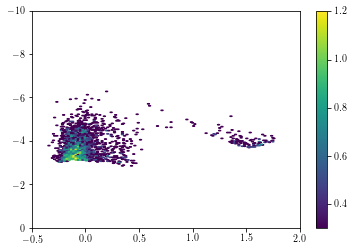

In [11]:
#The full CMD
plt.hexbin(good['(BP_RP)_0'],good['M_G'],mincnt=1,bins='log')

plt.xlim(-0.5,2)
plt.ylim(0,-10)
plt.colorbar()

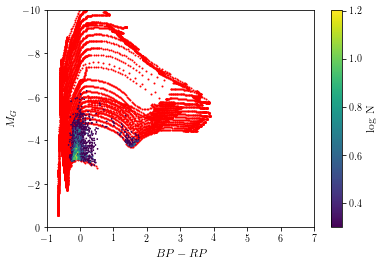

In [12]:
#So here are all of our stars, and a dividing line.

plt.scatter(mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev'],mist_massive['Gaia_G_DR2Rev'],s=1,c='r')
plt.hexbin(good['(BP_RP)_0'],good['M_G'],mincnt=1,bins='log')

plt.xlim(-1,7)
plt.ylim(0,-10)
plt.colorbar(label = 'log N')

plt.xlabel('$BP-RP$')
plt.ylabel('$M_G$')

plt.savefig('CMD_massive_MIST.png')

Text(0,0.5,'N')

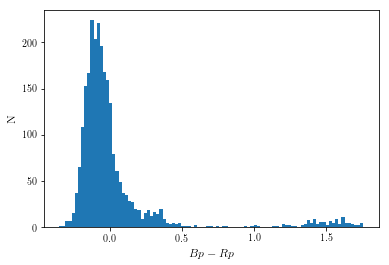

In [13]:
#Distribution of Bp - Rp
plt.hist(good['(BP_RP)_0'],bins='auto')
plt.xlabel(r'$Bp-Rp$')
plt.ylabel('N')

Text(0,0.5,'N')

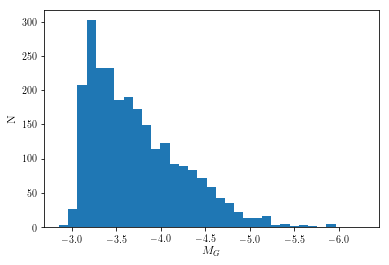

In [14]:
#Distribution of Absolute G mag
plt.hist(good['M_G'],bins='auto');
plt.gca().invert_xaxis()
plt.xlabel(r'$M_G$')
plt.ylabel('N')

# Now let's play with the sample a bit, make some plots

In [63]:
MainSequence = good[good['(BP_RP)_0'] < 0.5]
PostMainSequence = good[good['(BP_RP)_0'] >= 0.5]

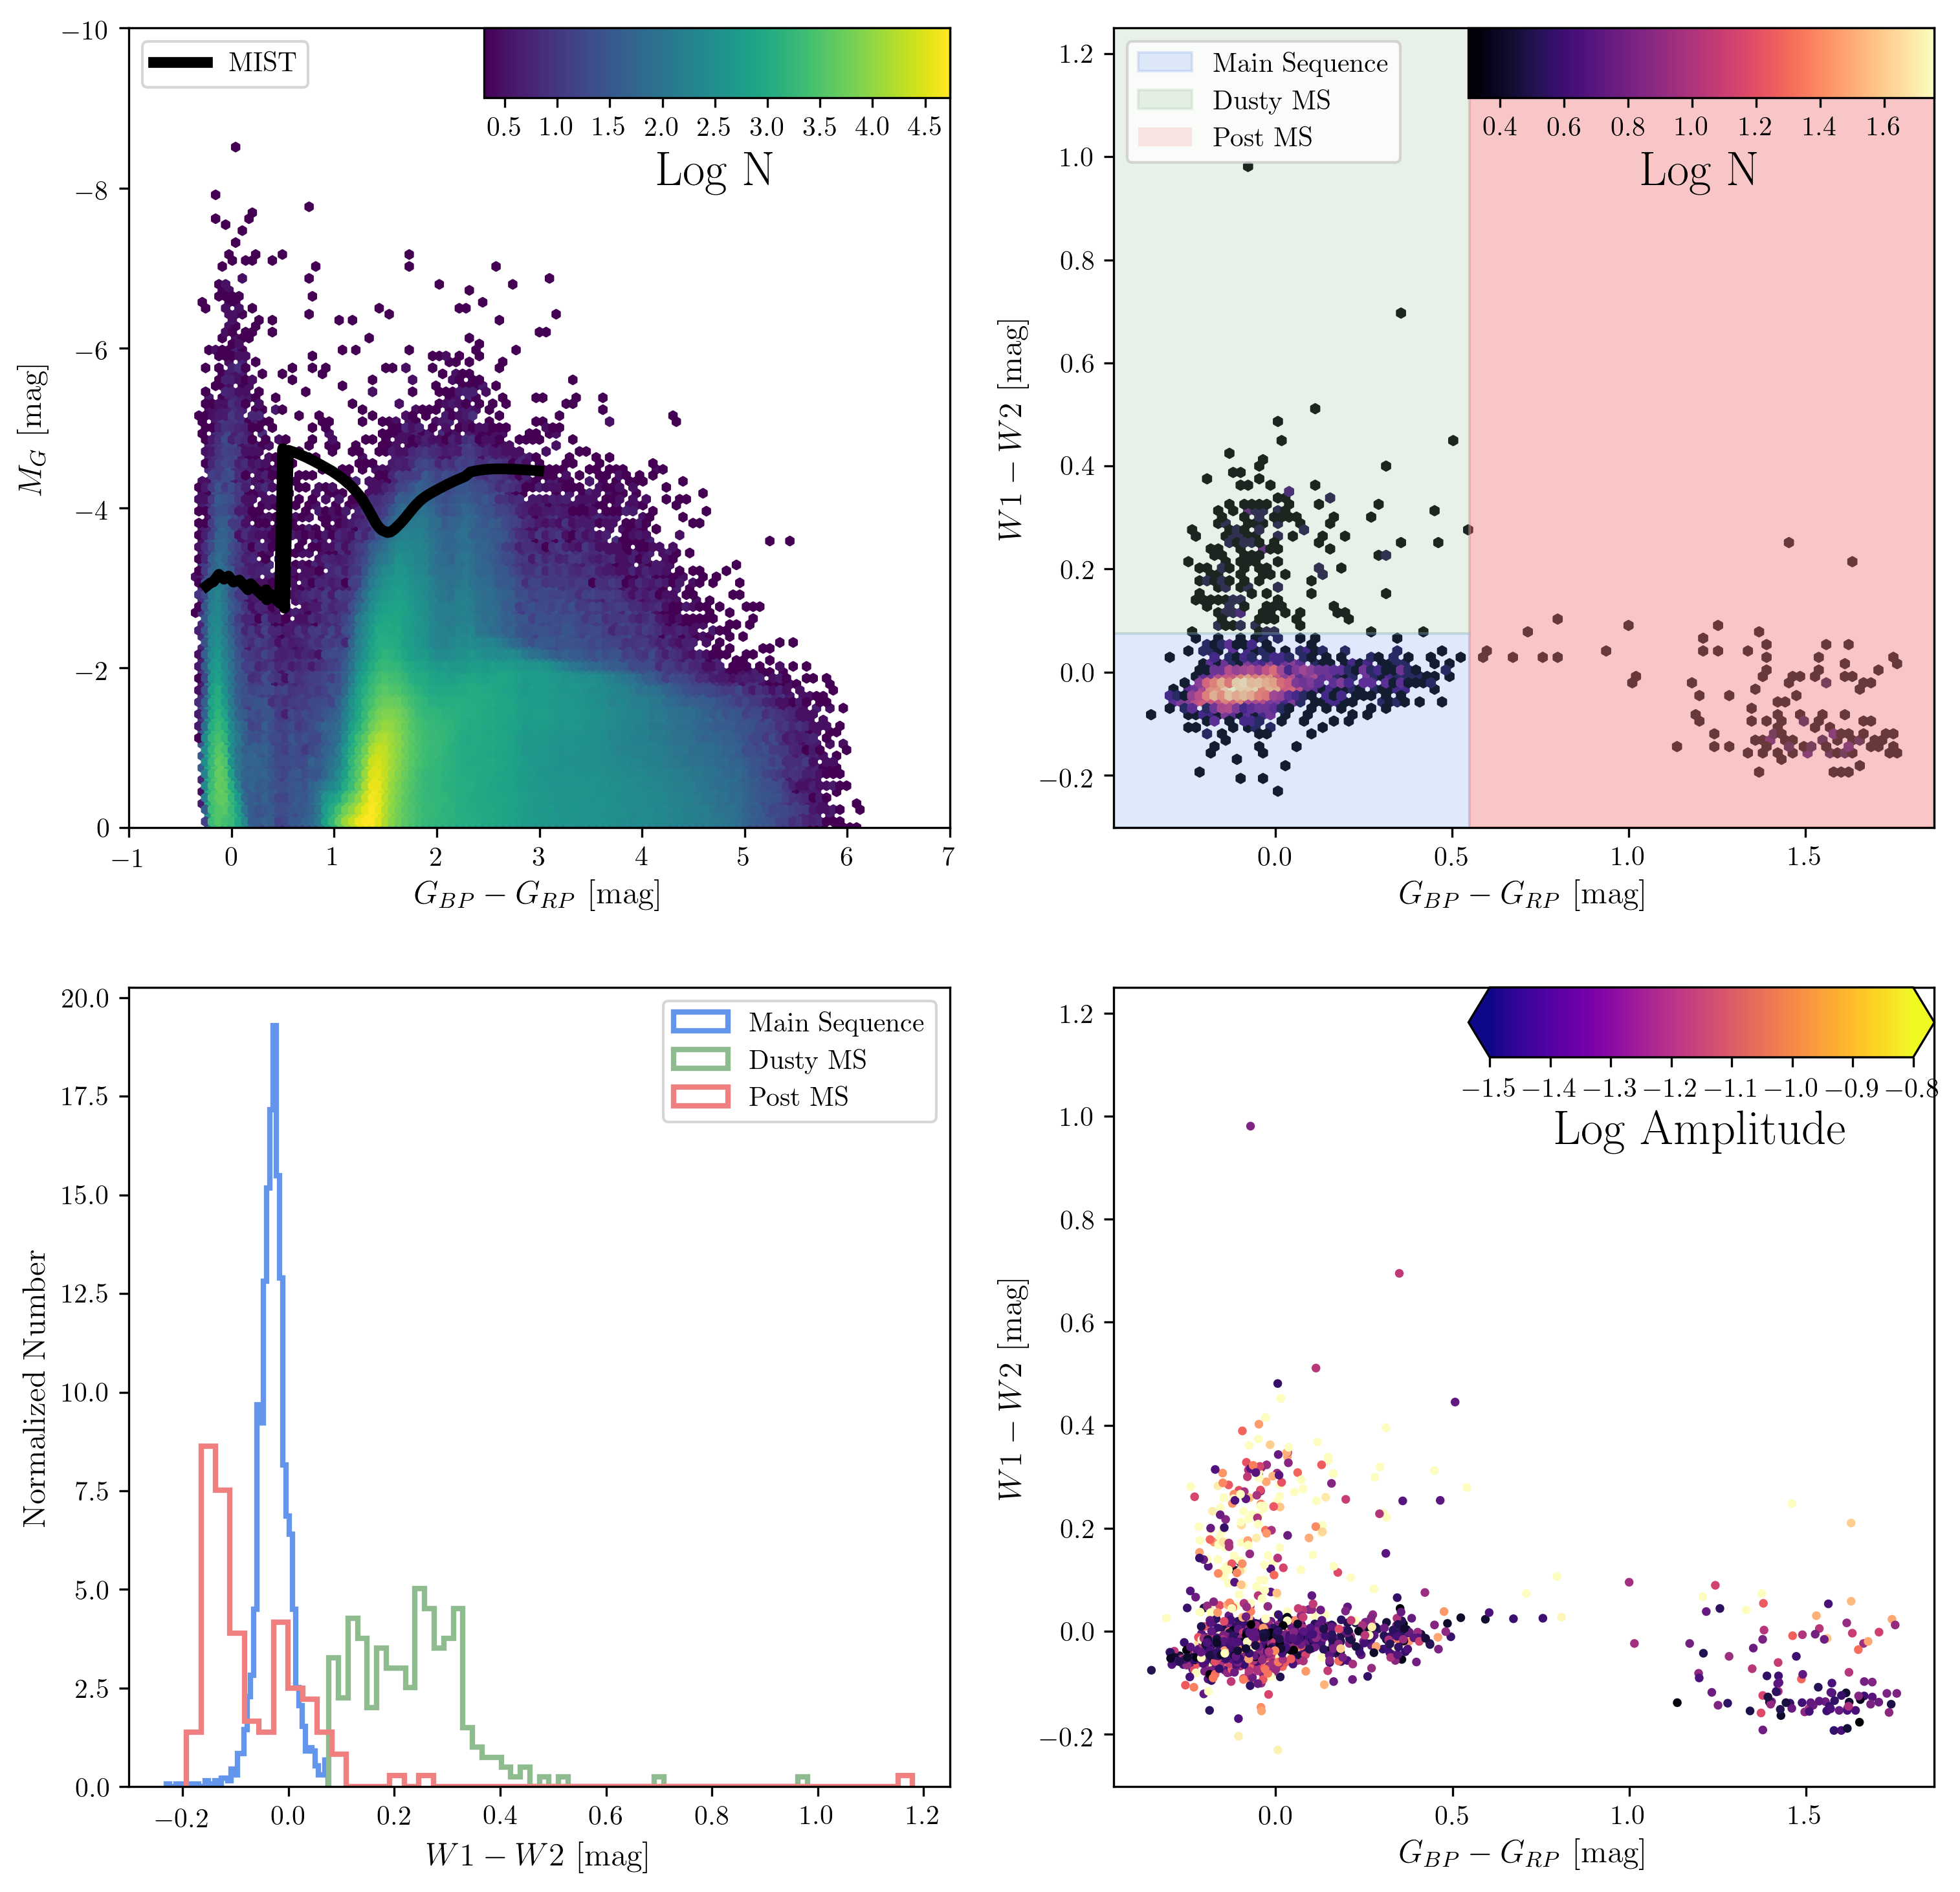

In [58]:
fig, axes = plt.subplots(2,2,figsize=(12,12),dpi=300)

axes[0,0].plot(min_cols,min_mags,'-k',lw=4,label='MIST')
axes[0,0].legend(loc=2)
hexb = axes[0,0].hexbin(result['(BP_RP)_0'],result['M_G'],mincnt=1,bins='log')
axes[0,0].set(xlim=(-1,7), ylim=(0,-10), xlabel=(r'$G_{BP}-G_{RP}$ [mag]'), ylabel=('$M_G$ [mag]'))

hexclim = hexb.get_clim()
cbax = fig.add_subplot(111)
bounds = axes[0,0].get_position()
cbax.set_position([bounds.x0+bounds.width-0.2,bounds.y0+bounds.height-0.03, 0.2, 0.03])
norm = colors.Normalize(vmin=hexclim[0], vmax=hexclim[1])
cb1 = cbar.ColorbarBase(cbax, cmap='viridis',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Log N',fontsize=18)

opt_color = good['(BP_RP)_0']
ir_color = good['W1-W2']
hexb = axes[0,1].hexbin(opt_color,ir_color,mincnt=1, bins='log', cmap='magma')
colax_xlim = axes[0,1].get_xlim()
colax_ylim = axes[0,1].get_ylim()
axes[0,1].fill([colax_xlim[0],0.55,0.55,colax_xlim[0]],[colax_ylim[0],colax_ylim[0],0.075,0.075],
           alpha=0.2,c='cornflowerblue',label='Main Sequence')
axes[0,1].fill([colax_xlim[0],0.55,0.55,colax_xlim[0]],[0.075,0.075,colax_ylim[1],colax_ylim[1]],
           alpha=0.2,c='darkseagreen',label='Dusty MS')
axes[0,1].axvspan(xmin=0.55,xmax=colax_xlim[1],facecolor='lightcoral',
              alpha=0.2,label='Post MS')
axes[0,1].fill([0.55,colax_xlim[1],colax_xlim[1],0.55],[colax_ylim[0],colax_ylim[0],colax_ylim[1],colax_ylim[1]],
           alpha=0.3,c='lightcoral',label='Dusty MS')
axes[0,1].set(xlim=colax_xlim,ylim=colax_ylim,xlabel=r'$G_{BP}-G_{RP}$ [mag]',ylabel=r'$W1-W2$ [mag]')
h,l = axes[0,1].get_legend_handles_labels()
axes[0,1].legend(h[:3], l[:3])
hexclim = hexb.get_clim()
cbax = fig.add_subplot(121)
bounds = axes[0,1].get_position()
cbax.set_position([bounds.x0+bounds.width-0.2,bounds.y0+bounds.height-0.03, 0.2, 0.03])
norm = colors.Normalize(vmin=hexclim[0], vmax=hexclim[1])
cb1 = cbar.ColorbarBase(cbax, cmap='magma',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Log N',fontsize=18)

mainsequence = bright[(bright['(BP_RP)_0']<=0.55)&(bright['W1-W2']<=0.075)]
dustyms = bright[(bright['(BP_RP)_0']<=0.55)&(bright['W1-W2']>0.075)]
postms = bright[(bright['(BP_RP)_0']>0.55)]
dfs = [mainsequence,dustyms,postms]
cs = ['cornflowerblue','darkseagreen','lightcoral']
labels = ['Main Sequence','Dusty MS','Post MS']
for df,c,l in zip(dfs,cs,labels):
    axes[1,0].hist(df['W1-W2'],color=c,label=l,histtype='step',density=True,bins=50,lw=2)
axes[1,0].legend()
axes[1,0].set(xlabel='$W1-W2$ [mag]',ylabel='Normalized Number')

bright_features = pd.read_csv('../../code/massive_features.csv')
sample = pd.read_csv('massive.csv.gz')
bright_features.drop(columns=['Unnamed: 0'],inplace=True)
bright = pd.merge(sample,bright_features,left_on='original_ext_source_id',right_on='Name')
opt_color = bright['(BP_RP)_0']
ir_color = bright['W1-W2']
scat = axes[1,1].scatter(opt_color,ir_color,c=np.log10(bright['Amplitude']), s=5, cmap='magma')
colax_xlim = axes[1,1].get_xlim()
colax_ylim = axes[1,1].get_ylim()
axes[1,1].set(xlim=colax_xlim,ylim=colax_ylim,xlabel=r'$G_{BP}-G_{RP}$ [mag]',ylabel=r'$W1-W2$ [mag]')
scat.set_clim(-1.5,-0.8)
scatclim = scat.get_clim()
cbax = fig.add_subplot(122)
bounds = axes[1,1].get_position()
cbax.set_position([bounds.x0+bounds.width-0.2,bounds.y0+bounds.height-0.03, 0.2, 0.03])
norm = colors.Normalize(vmin=scatclim[0], vmax=scatclim[1])
cb1 = cbar.ColorbarBase(cbax, cmap='plasma',
                                norm=norm,
                                orientation='horizontal',
                                extend='both')
cb1.set_label('Log Amplitude',fontsize=18)

plt.savefig('sample_plots.pdf')

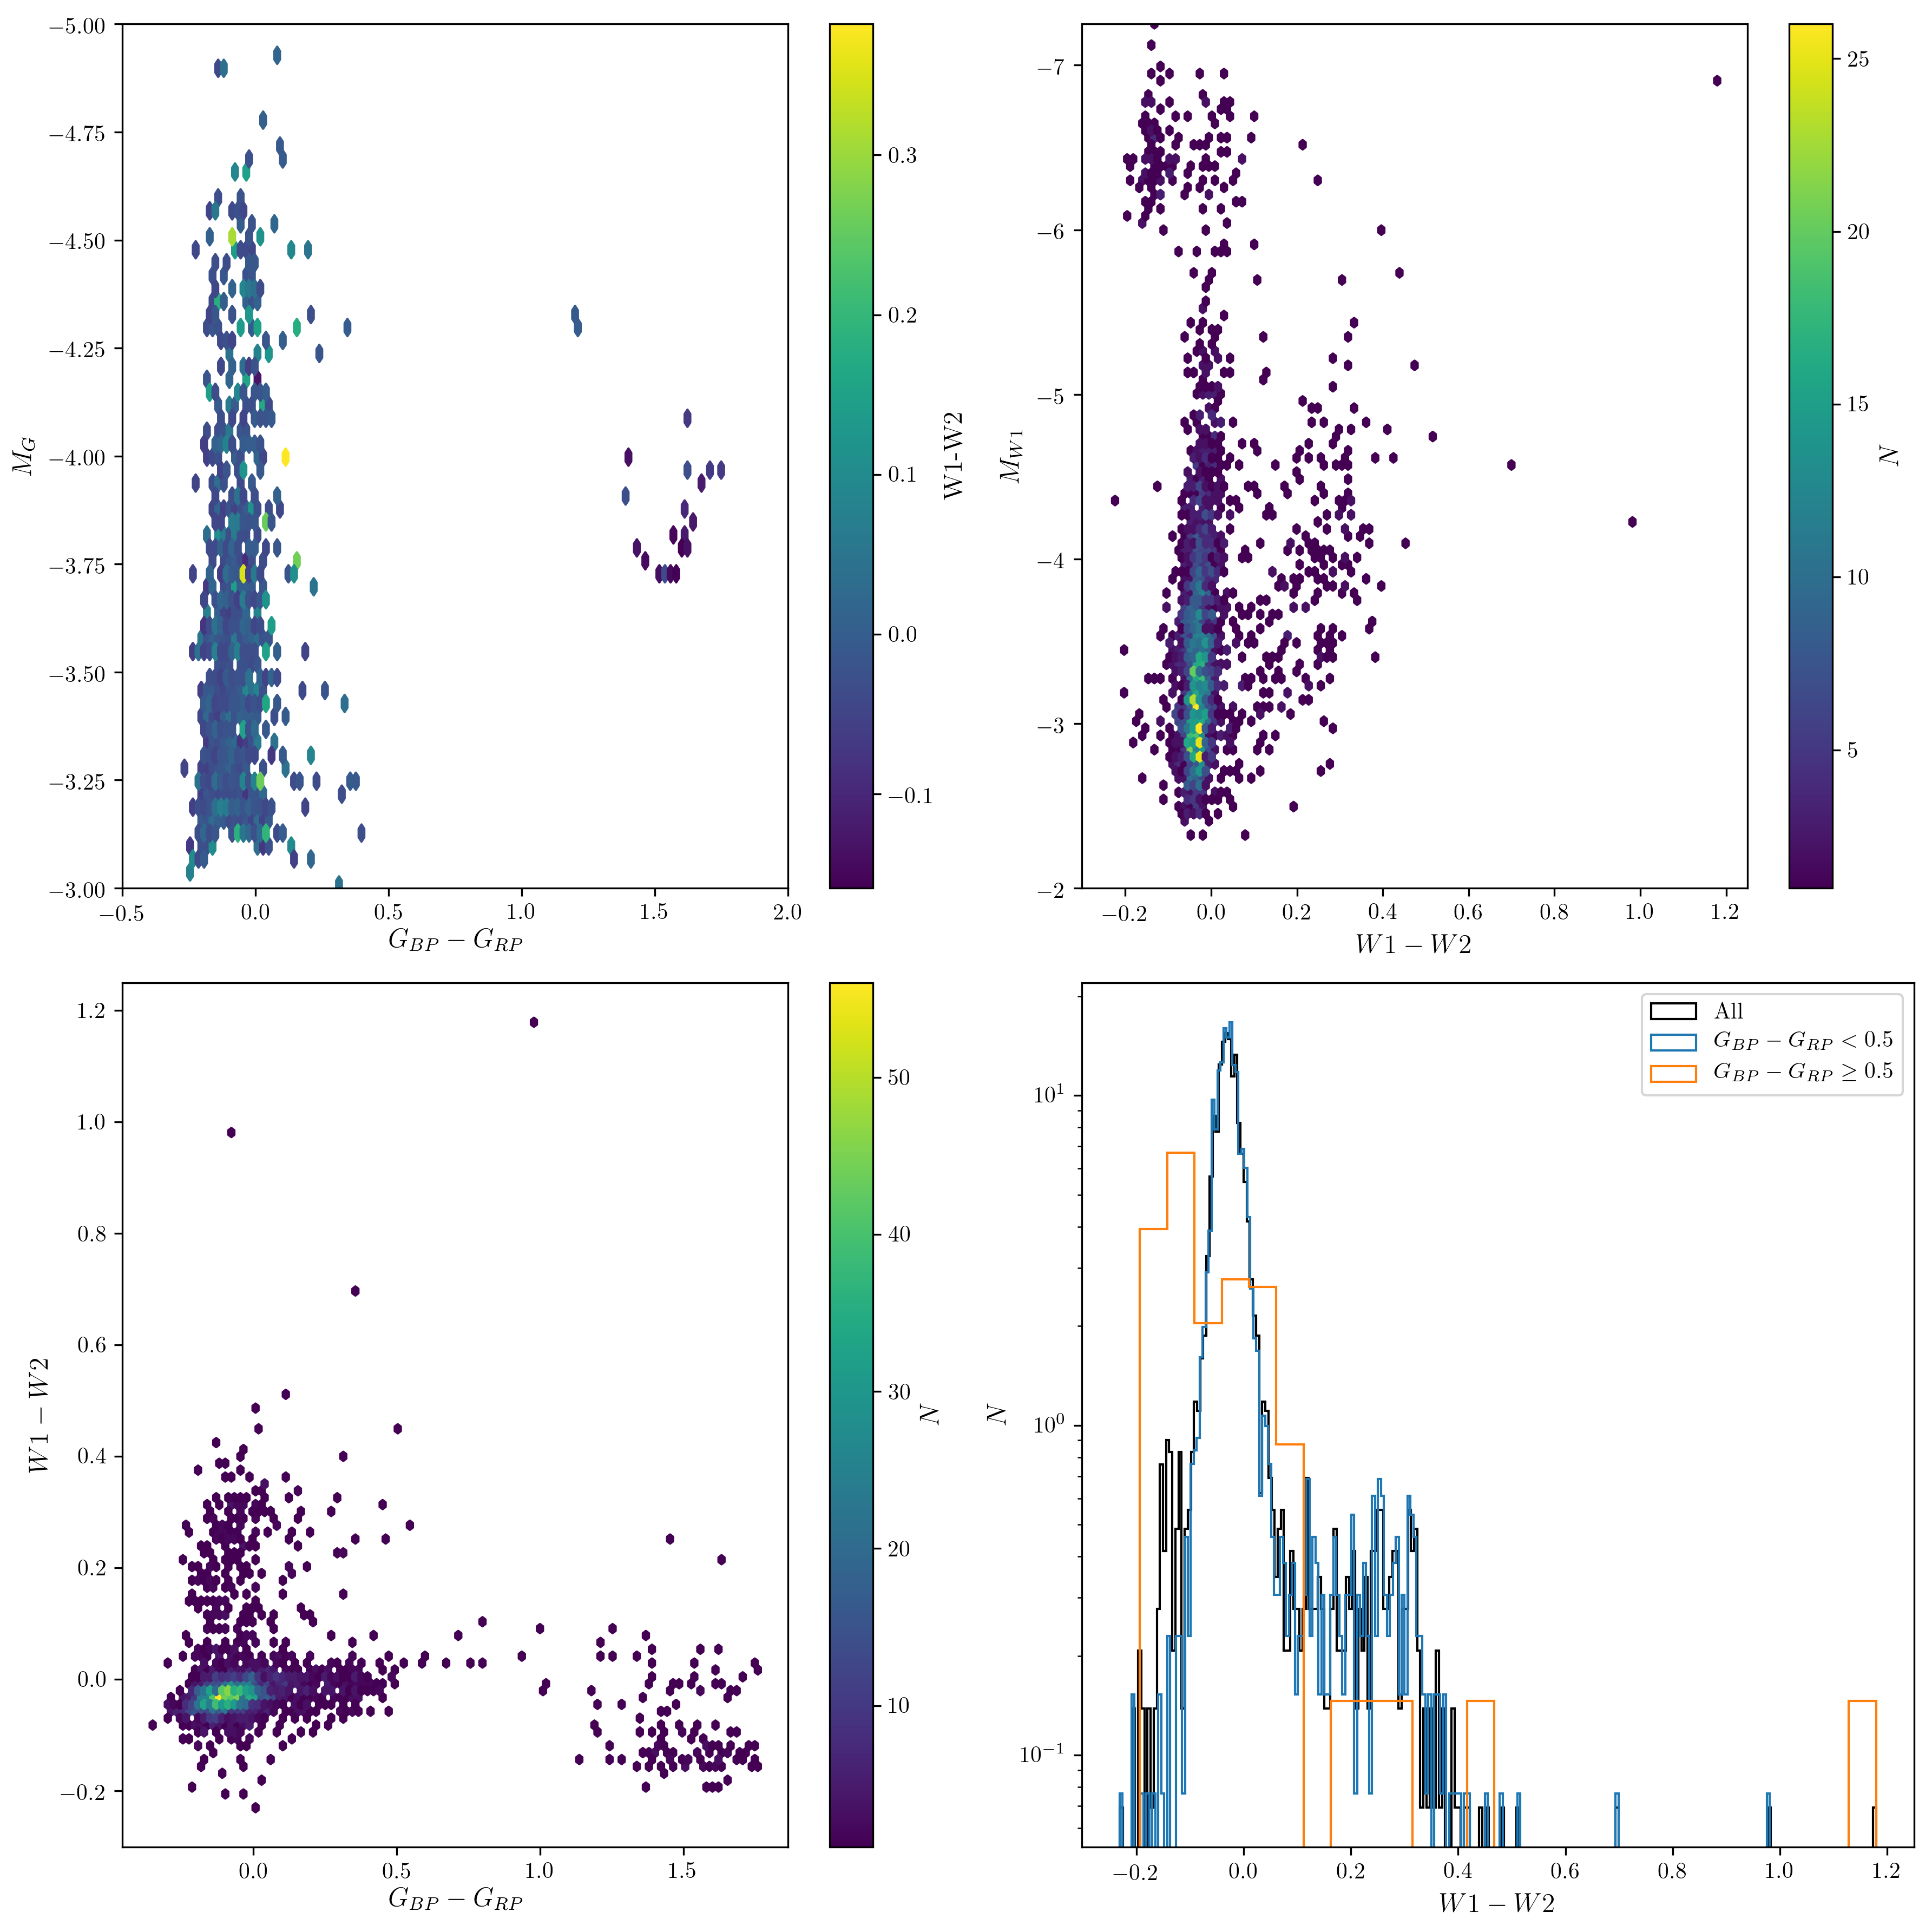

In [72]:
fig, axes = plt.subplots(2,2,figsize=(12,12),dpi=300)

p1 = axes[0,0].hexbin(good['(BP_RP)_0'],good['M_G'],
           C = good['w1mpro']-good['w2mpro'],mincnt=1)
plt.colorbar(p1, ax=axes[0,0], label='W1-W2')
axes[0,0].set(xlim=(-0.5,2), ylim=(-3,-5), xlabel=(r'$G_{BP}-G_{RP}$'), ylabel=('$M_G$'))

p2 = axes[0,1].hexbin(good['W1-W2'],good['M_W1'],
           mincnt=1)
plt.colorbar(p2, ax=axes[0,1], label=r'$N$')
axes[0,1].set(ylim=(-2,-7.25), xlabel=('$W1-W2$'), ylabel=('$M_{W1}$'))
axes

p3 = axes[1,0].hexbin(good['(BP_RP)_0'],good['w1mpro']-good['w2mpro'],
           mincnt=1)
plt.colorbar(p3, ax=axes[1,0], label=r'$N$')
axes[1,0].set(ylabel='$W1-W2$', xlabel=r'$G_{BP}-G_{RP}$')


axes[1,1].hist(good['w1mpro']-good['w2mpro'], 
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, color='k',
         label=r'All')
axes[1,1].hist(MainSequence['w1mpro']-MainSequence['w2mpro'], 
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, 
         label=r'$G_{BP}-G_{RP} < 0.5$')
axes[1,1].hist(PostMainSequence['w1mpro']-PostMainSequence['w2mpro'],
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, 
         label=r'$G_{BP}-G_{RP} \geq 0.5$')
axes[1,1].legend()
axes[1,1].set(yscale='log', xlabel='$W1-W2$', ylabel='$N$')
fig.tight_layout()
plt.savefig('coarsesample.eps')

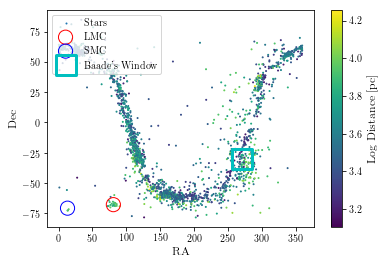

In [106]:
plt.scatter(good['ra'],good['dec'],s=1,c=np.log10(good['r_est']),label='Stars')
plt.colorbar(label='Log Distance [pc]')
plt.scatter(15.0*(5+23/60+34/3600),-69+45/60+22/3600,s=200, facecolors='none', edgecolors='r',label='LMC')
plt.scatter(15.0*(52/60+45/3600),-72+49/60+43/3600,s=200, facecolors='none', edgecolors='b',label='SMC')
plt.scatter(15*(18+3/60+31.2/3600),-30+1/60+12/3600,s=400, marker='s', lw=3, facecolors='none', edgecolors='c',label="Baade's Window")
plt.legend(loc=2)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.savefig('locations.png')

In [109]:
import astropy.units as u
from astropy.coordinates import SkyCoord
c = SkyCoord(ra=good['ra'].values*u.degree, dec=good['dec'].values*u.degree, distance=good['r_est'].values*u.pc)

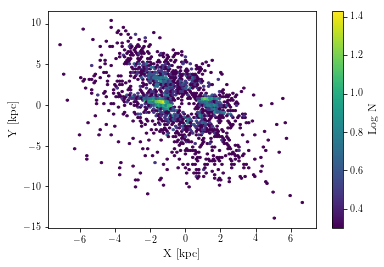

In [118]:
plt.hexbin(c.cartesian.x*1e-3,c.cartesian.y*1e-3,mincnt=1,bins='log',label='Stars')
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.colorbar(label='Log N')

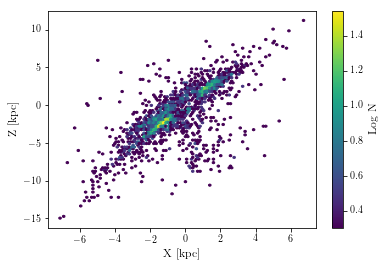

In [119]:
plt.hexbin(c.cartesian.x*1e-3,c.cartesian.z*1e-3,mincnt=1,bins='log',label='Stars')
plt.xlabel('X [kpc]')
plt.ylabel('Z [kpc]')
plt.colorbar(label='Log N')

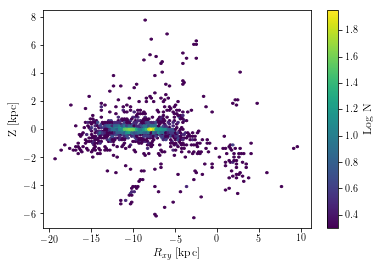

In [154]:
plt.hexbin(np.sign(c.galactocentric.x.value)*np.sqrt((c.galactocentric.x.value*1e-3)**2.0+(c.galactocentric.y.value*1e-3)**2.0),c.galactocentric.z*1e-3,mincnt=1,bins='log',label='Stars')
plt.xlabel('$R_{xy}$ [kpc]')
plt.ylabel('Z [kpc]')
plt.colorbar(label='Log N')

In [ ]:
c.galactocentric.x

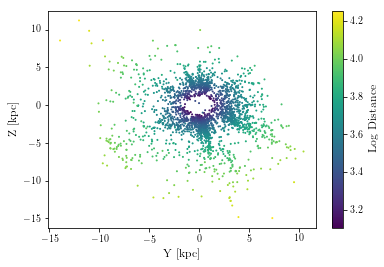

In [116]:
plt.scatter(c.cartesian.y*1e-3,c.cartesian.z*1e-3,s=1,c=np.log10(good['r_est']),label='Stars')
plt.xlabel('Y [kpc]')
plt.ylabel('Z [kpc]')
plt.colorbar(label='Log Distance')

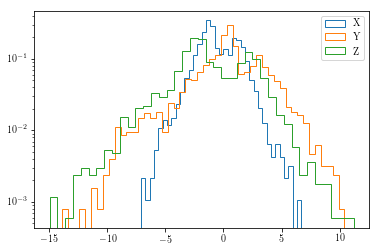

In [126]:
plt.hist(c.cartesian.x.value*1e-3,bins='auto', normed=True, stacked=True, 
         histtype='step', lw=1, label='X')
plt.hist(c.cartesian.y.value*1e-3,bins='auto', normed=True, stacked=True, 
         histtype='step', lw=1, label='Y')
plt.hist(c.cartesian.z.value*1e-3,bins='auto', normed=True, stacked=True, 
         histtype='step', lw=1, label='Z')
plt.yscale('log')
plt.legend()

In [59]:
#Let's write out to CSV
good.to_csv('massive.csv.gz',index=False,compression='gzip')

# Some analysis

Text(0.5,0,'$W1-W2$')

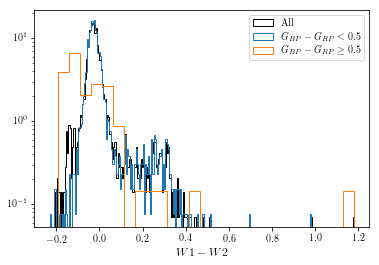

In [127]:
plt.hist(good['w1mpro']-good['w2mpro'], 
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, color='k',
         label=r'All')
plt.hist(MainSequence['w1mpro']-MainSequence['w2mpro'], 
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, 
         label=r'$G_{BP}-G_{RP} < 0.5$')
plt.hist(PostMainSequence['w1mpro']-PostMainSequence['w2mpro'],
         bins='auto', normed=True, stacked=True, histtype='step', lw=1, 
         label=r'$G_{BP}-G_{RP} \geq 0.5$')
plt.legend()
plt.yscale('log')
plt.xlabel('$W1-W2$')

Text(0.5,0,'W1-W2')

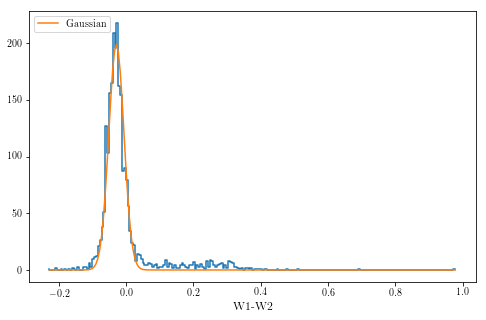

In [128]:
#Fit the MS with a Gaussian
num,bins=np.histogram(MainSequence['w1mpro']-MainSequence['w2mpro'],bins='auto')
bin_centers = bins[:-1] + 0.5*np.diff(bins)
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
# Fit the data using a Gaussian
g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
fit_g = fitting.LevMarLSQFitter()
g = fit_g(g_init, bin_centers, num)

# Plot the data with the best-fit model
plt.figure(figsize=(8,5))
plt.step(bin_centers, num)
plt.plot(bin_centers, g(bin_centers), label='Gaussian')
plt.legend(loc=2)
plt.xlabel('W1-W2')

In [129]:
z_scores = (MainSequence['w1mpro']-MainSequence['w2mpro']- g.mean)/g.stddev
weird_MS = MainSequence[np.abs(z_scores)>=3]

Text(0,0.5,'W1-W2')

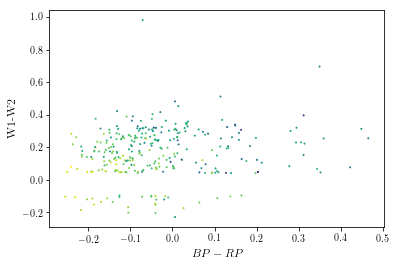

In [134]:
plt.scatter(weird_MS['(BP_RP)_0'],weird_MS['w1mpro']-weird_MS['w2mpro'],s=1,
           c=weird_MS['M_W1'])
plt.xlabel(r'$BP-RP$')
plt.ylabel('W1-W2')

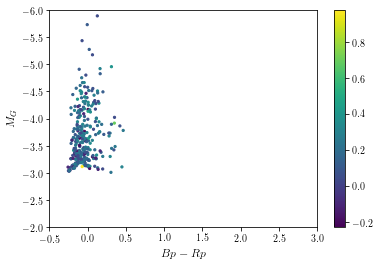

In [133]:
plt.scatter(weird_MS['(BP_RP)_0'],weird_MS['M_G'],
          c=weird_MS['w1mpro']-weird_MS['w2mpro'],s=5)

plt.xlim(-0.5,3)
plt.ylim(-2,-6)
plt.xlabel('$Bp-Rp$')
plt.ylabel('$M_G$')
plt.colorbar()